##### Modelo SEIR (Susceptibles, Expuestos, Infectados, Recuperados, Fallecidos) + Detectados

In [1]:
import numpy as np
import scipy
import scipy.integrate
import lmfit

from utilidades import *

def seir_model(SEIR, beta, sigma, gamma, mu, theta=0, beta_d=0):
    S, E, I, D, R, F = SEIR

    # Poblacion
    N = S + E + I + D + R

    # - Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # - Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    dS = - beta * S * I / N - beta_d * S * D / N
    # + Los susceptibles que pasan a expuestos a razon `beta` (infectados no detectados)
    # + Los susceptibles que pasan a expuestos a razon `beta_d` (infectados detectados)
    # - Los expuestos que pasan a infectados a razon `sigma`
    dE = beta * S * I / N + beta_d * S * D / N - sigma * E
    # + Los expuestos que pasan a infectados no detectados a razon `sigma`
    # - Los infectados no detectados que pasan a recuperados a razon `gamma`
    # - Los infectados no detectados que pasan a fallecidos a razon `mu`
    # - Los infectados no detectados que pasan a detectados a razon `theta`
    dI = sigma * E - gamma * I - mu * I - theta * I
    # + Los infectados no detectados que pasan a detectados a razon `theta`
    # - Los detectados que pasan a recuperados a razon `gamma`
    # - Los detectados que pasan a fallecidos a razon `mu`
    dD = theta * I - gamma * D - mu * D
    # + Los infectados no detectados que pasan a recuperados a razon `gamma`
    # + Los detectados que pasan a recuperados a razon `gamma`
    dR = gamma * I + gamma * D
    # + Los infectados no detectados que pasan a fallecidos a razon `mu`
    # + Los detectados que pasan a fallecidos a razon `mu`
    dF = mu * I + mu * D

    return [
        dS, dE, dI, dD, dR, dF
    ]

Clases:
    * Susceptible
    * Expuesto
    * Infectado
    * Recuperado
    * Fallecido
Nueva Clase:
    * Detectado - Infectado Detectado
    
Parametros:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  
    * `mu` es la razon de transicion de Infectado a Fallecido
Nuevos Parametros:  
    * `theta` es la razon de transicion de Infectado a Detectado  
    * `beta_d` es la razon de transmision de los Detectados  


In [2]:
periodo_incubacion = 5.2
periodo_infeccioso = 12.4
razon_mortalidad = 3.4 / 100.0

infectados_t0 = 16.
susceptibles_t0 = 11e6

data = load_data()

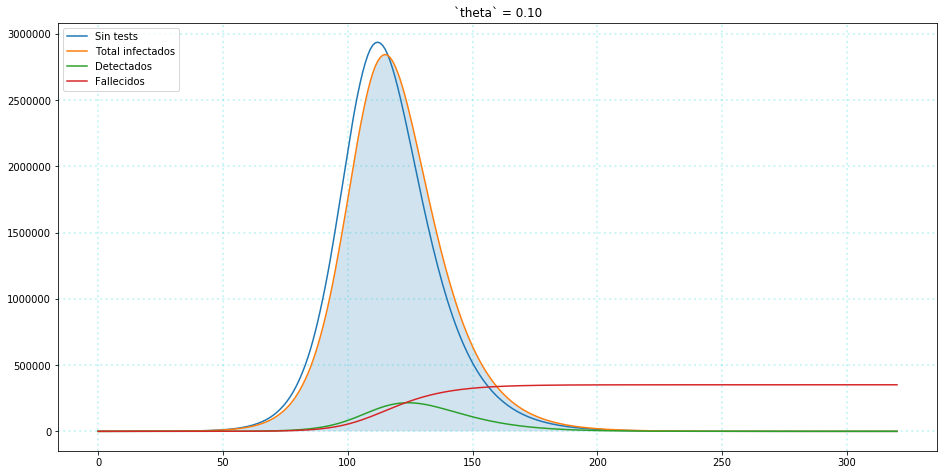

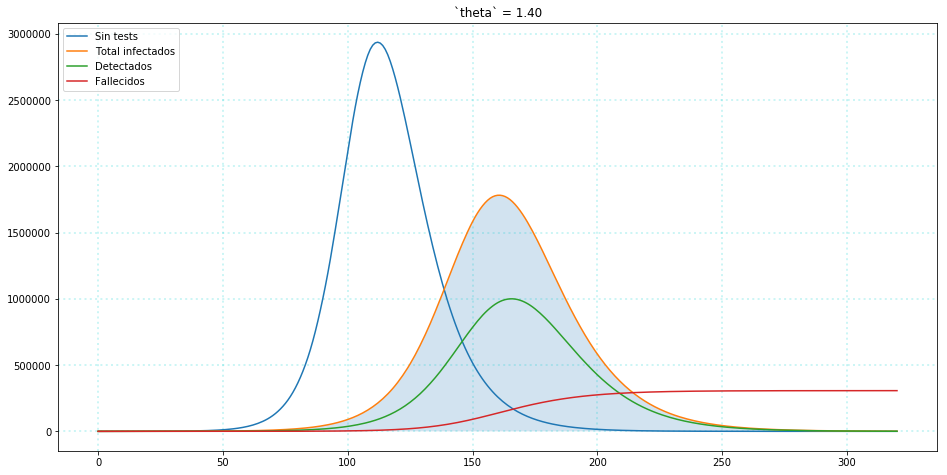

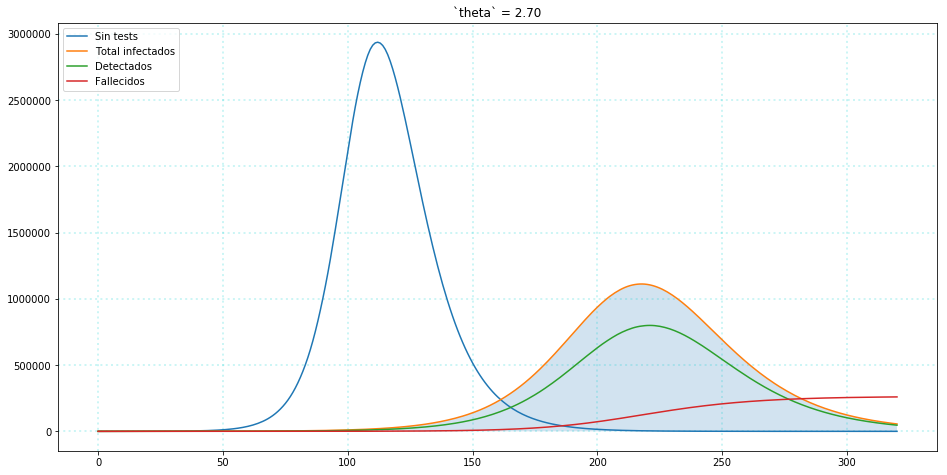

In [9]:
def run_model(params):
    if type(params) == lmfit.Parameters:
        params = [param.value for param in params.values()]
    
    if len(params) > 2:
        R0, R1, theta = params
        beta = [R_t / periodo_infeccioso for R_t in (R0, R1)]
    else:
        R0, theta = params
        beta = R0 / periodo_infeccioso
    
    SEIR_t0 = (
        susceptibles_t0,
        infectados_t0 * R0, # expuestos
        infectados_t0,
        0, 0, 0 # detectados, recuperados, fallecidos
    )
    return run(
        seir_model,
        SEIR_t0,
        beta = beta,
        sigma = 1. / periodo_incubacion,
        gamma = 1. / periodo_infeccioso,
        mu = razon_mortalidad / periodo_infeccioso,
        theta = theta / periodo_infeccioso,
        beta_d = 1. / periodo_infeccioso,
        days = days,
        step = 1
    )

days = [20, 300]

var_range = np.arange(start=0., stop=4., step=0.1)
solutions = [
    (var, run_model((4., var))) for var in var_range
]

solutions_x = solutions[0][1]['t']
solution_base = solutions[0][1]['y'][3] + solutions[0][1]['y'][2]

for _ in range(1, 30, 13):
    solution_infected = solutions[_][1]['y'][3] + solutions[_][1]['y'][2]
    
    ax = plot(solutions_x, solution_base, labels=['Sin tests'])
    ax.plot(solutions_x, solution_infected, label='Total infectados')
    ax.plot(solutions_x, solutions[_][1]['y'][3], label='Detectados')
    ax.plot(solutions_x, solutions[_][1]['y'][-1], label='Fallecidos')
    ax.fill_between(
        solutions_x,
        solutions[0][1]['y'][3],
        solution_infected,
        alpha=0.2
    )
    ax.set_title('`theta` = {:.2f}'.format(solutions[_][0]))
    ax.legend(loc='upper left')

`theta` y `beta_d` describen cuanto (`theta` = `R_0` * `% reduccion / 100`) y cuan rapido se detecto y que tan bien se aislo a los infectados cosa de reducir el `R_D` efectivo del infectado detectado a `beta_d` * `periodo_infeccioso`, en las simulaciones `R_D` = 1.  

La curva `Sin tests` se genera a partir de un `R0` = 4.0.  

![Intervenciones](./img/1.png)
<center>Efecto estimado de las intervenciones del gobierno en el reino unido (fin de marzo)</center>

<b>Cuantas son bastantes pruebas y como afectan a la curva de contagios?</b> 

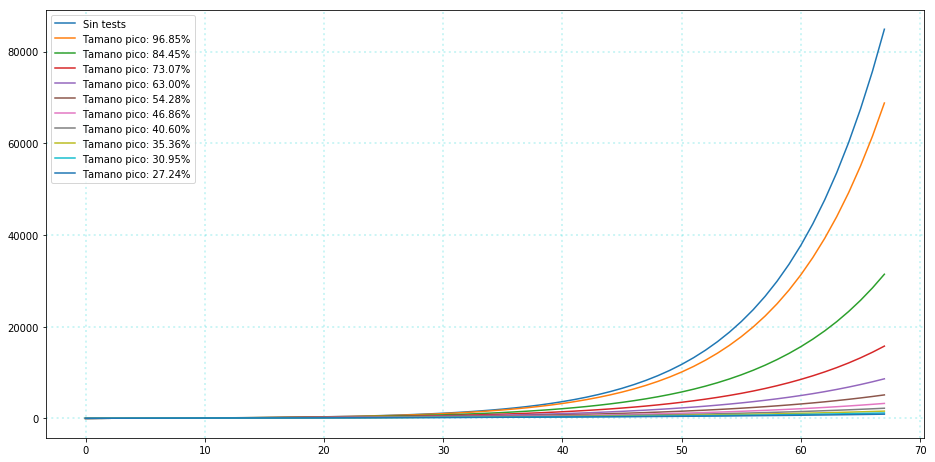

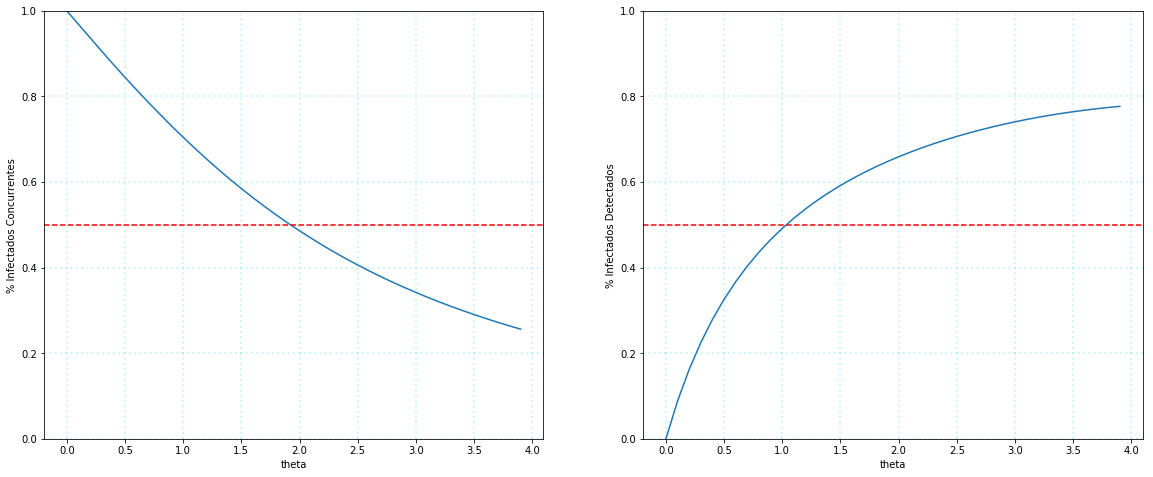

In [4]:
to_day = len(data[0]) + 14
solutions_x_capped = solutions_x[:to_day]

ax = plot(solutions_x_capped, solution_base[:to_day], labels=['Sin tests'])

total_infected = [
    solutions[_][1]['y'][3] + solutions[_][1]['y'][2] for _ in range(len(solutions))
]
concurrent_infected = [
    max(total_infected[_]) / max(solution_base) for _ in range(len(solutions))
]
percentage_detected = [
    sum(solutions[_][1]['y'][3]) / sum(total_infected[_]) for _ in range(len(solutions))
]

for _ in range(1, len(solutions), int(len(solutions)/10)):
    solution_infected = solutions[_][1]['y'][3] + solutions[_][1]['y'][2]
    ax.plot(
        solutions_x_capped, 
        solution_infected[:to_day], 
        label='Tamano pico: {:.2f}%'. format(concurrent_infected[_] * 100)
    )
    ax.legend(loc='upper left')


metrics = [concurrent_infected, percentage_detected]
labels = ['% Infectados Concurrentes', '% Infectados Detectados']
fig, axs = pyplot.subplots(figsize=(50 / 2.54, 20 / 2.54), ncols=2)

for idx, ax in enumerate(axs):
    ax.plot(var_range, metrics[idx])
    ax.axhline(y=0.5, color='r', linestyle='--')
    ax.set(xlabel='theta', ylabel=labels[idx])
    ax.set_ylim(bottom=0, top=1.)
    ax.grid(color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)



TODO: Describir

##### Regresion 

In [5]:
days = [12, len(data[0]) - 12]

def naive_fit():
#     normalized_data = data / np.linalg.norm(data, axis = 1, keepdims = True)
    
    def sqsum(R_ts):
        solution = run_model(R_ts)
        solution_data = np.array(solution['y'])
#         solution_data = solution_data / np.linalg.norm(solution_data, axis = 1, keepdims = True)
        
        return np.sum((solution_data[(3, 5),] - data[(0, 2),]) ** 2)
    
    return scipy.optimize.minimize(
        sqsum, (3., 1.), method='TNC', bounds=(
            (1.6, 5.2), (0.000001, 2.)
        )
    )

R_ts = naive_fit()
print('Lo logro?: {}'.format(R_ts.success))
R_ts = R_ts.x
R_ts

Lo logro?: False


array([4.27894328, 2.        ])

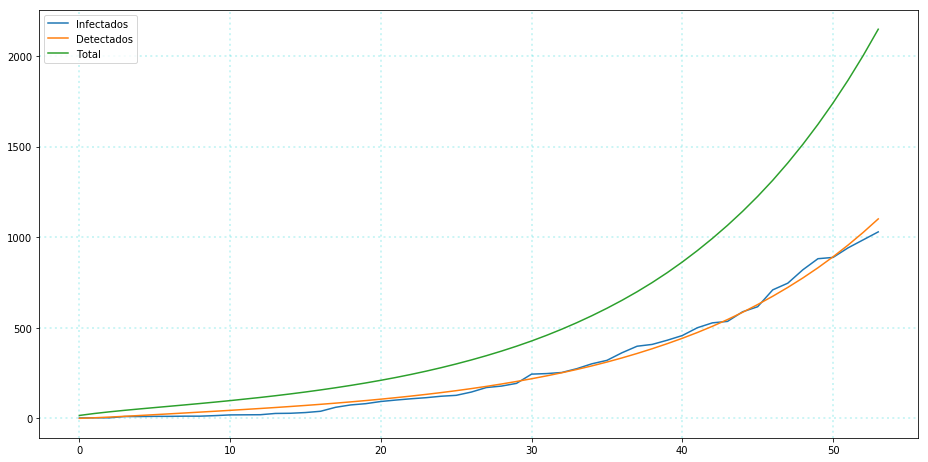

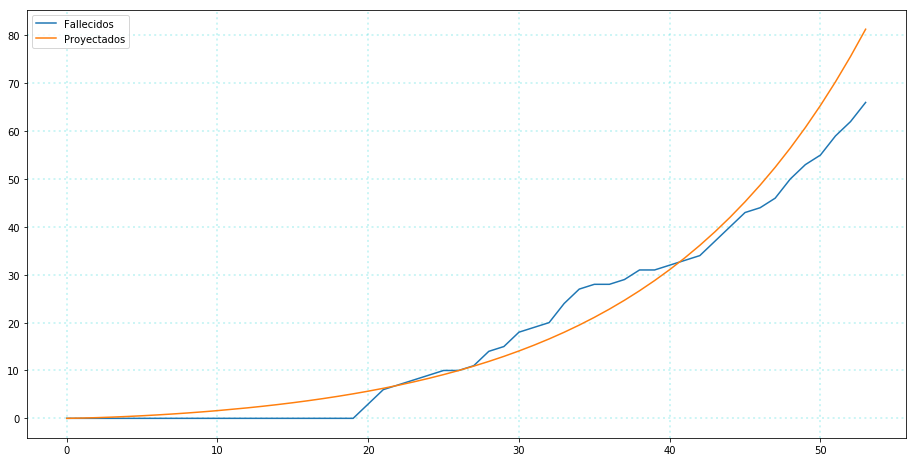

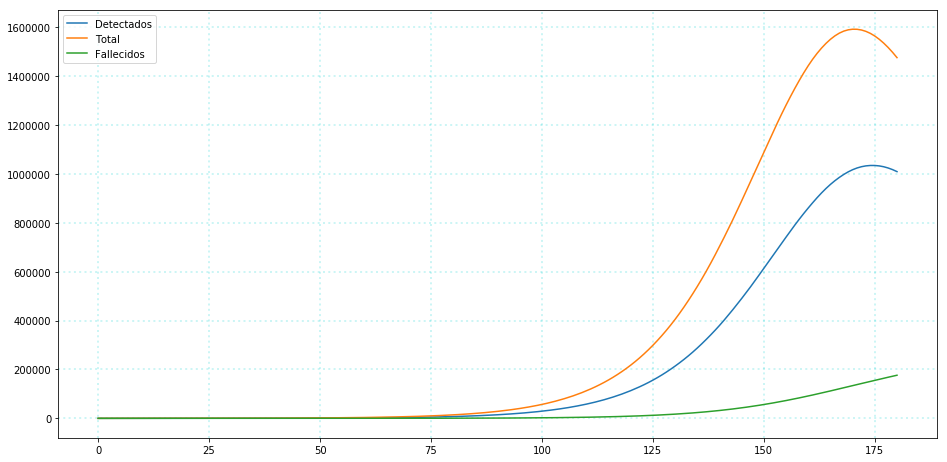

In [6]:
solution = run_model(R_ts)
# np.array(solution['y'])[(3, 5),]
plot(
    solution['t'], 
    data[0], solution['y'][3], solution['y'][3] + solution['y'][2],
    labels=[
        'Infectados', 'Detectados', 'Total',
    ]
)

plot(
    solution['t'], 
    data[2], solution['y'][5],
    labels=[
        'Fallecidos', 'Proyectados',
    ]
)

days = [12, 180 - 12]
solution = run_model(R_ts)

_ = plot(
    solution['t'], 
     solution['y'][3], solution['y'][3] + solution['y'][2], solution['y'][5],
    labels=[
        'Detectados', 'Total', 'Fallecidos'
    ]
)

Tremendo problema la regresion ahorita

In [7]:
days = [24, len(data[0]) - 24]

def naive_lmfit():
    params = lmfit.Parameters()
    params.add('R_0', value=3., min=1.6, max=5.)
    params.add('R_1', value=1., min=1.6, max=4.)
    params.add('theta', value=3., min=.3, max=3.)
    
    def sqsum(R_ts):
        solution = run_model(R_ts)
        solution_data = np.array(solution['y'])
        
        return (solution_data[(3, 5),] - data[(0, 2),])
    
    return lmfit.minimize(sqsum, params, method='differential_evolution')

R_ts = naive_lmfit()
R_ts

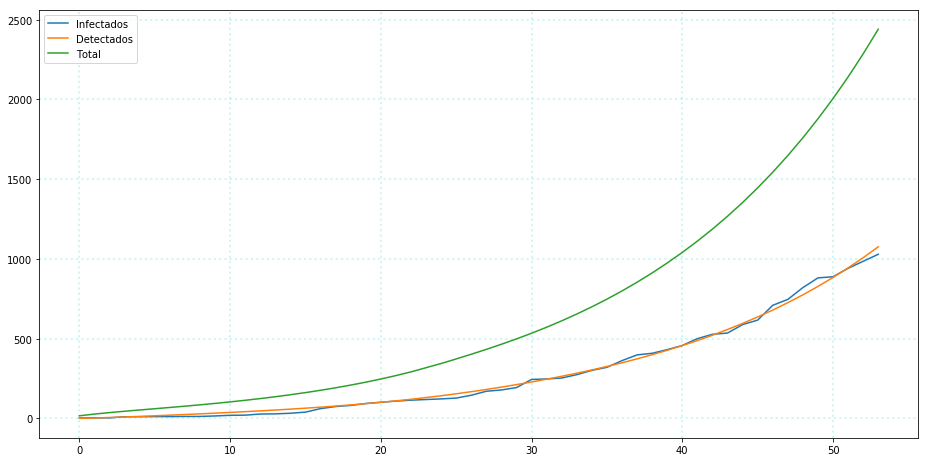

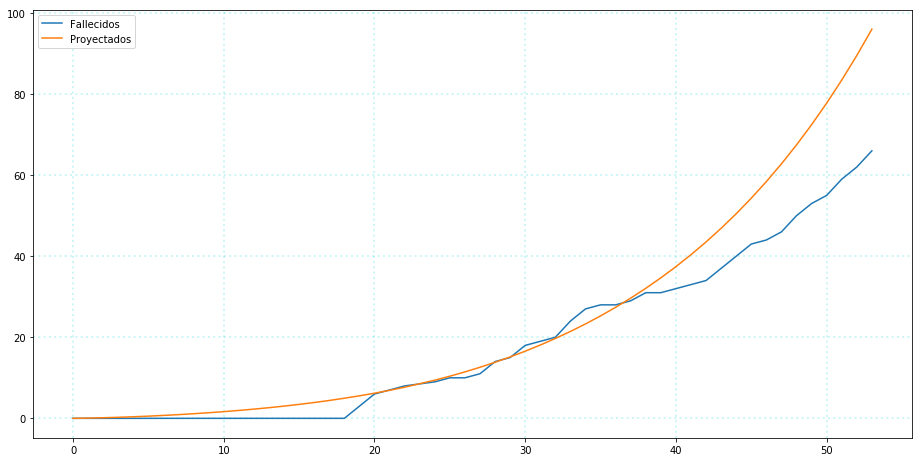

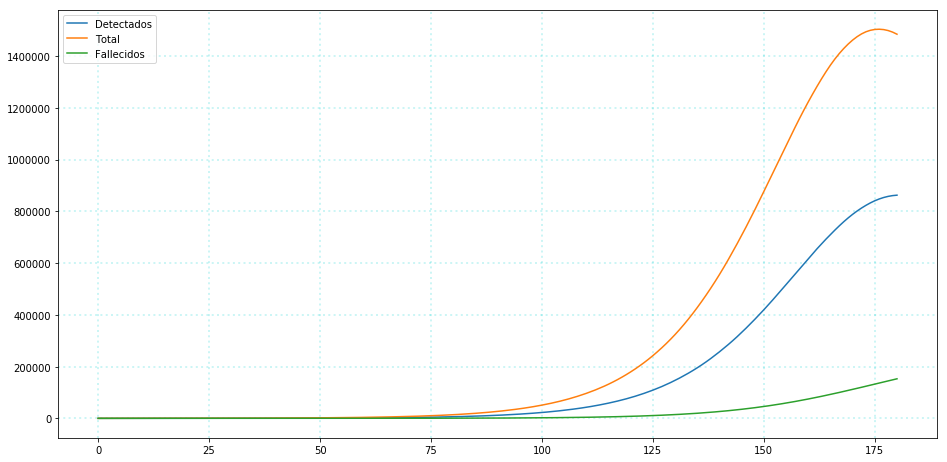

In [8]:
solution = run_model(R_ts.params)

plot(
    solution['t'], 
    data[0], solution['y'][3], solution['y'][3] + solution['y'][2],
    labels=[
        'Infectados', 'Detectados', 'Total',
    ]
)

plot(
    solution['t'], 
    data[2], solution['y'][5],
    labels=[
        'Fallecidos', 'Proyectados',
    ]
)
days = [23, 180 - 23]
solution = run_model(R_ts.params)

_ = plot(
    solution['t'], 
    solution['y'][3], solution['y'][3] + solution['y'][2], solution['y'][5],
    labels=[
        'Detectados', 'Total', 'Fallecidos'
    ]
)

Notas:
* El efecto de hacer pruebas y aislar a los infectados era obvio y ahora queda claro, no se pudo ver mucho mas, en el fitting mas modesto se proyecto ~ 2000 casos, 100% mas de los detectados al dia, no tiene sentido.
* Por ahora nada el fitting

Que hacer ahora?
* Como hacer explicito el contact tracing? Por ahora beta_d depende de un R_d que seria la efectividad de aislar al infectado y cuando se lo detecto, pero ese infectado crea una red de contactos que pasan directamente a observacion/aislacion/cuarentena, cuantos contactos ~?
* Agregar razon de fallo de los tests